# Modelo Multilíngue de Sentimento para E-commerce

Este notebook constrói um modelo de classificação de sentimento capaz de processar reviews em português (Olist + B2W) e espanhol (Amazon Reviews).

Objetivo:

    Unificar datasets heterogêneos

    Treinar modelo multi-output: prevê sentimento + idioma

    Exportar modelo pronto para produção (joblib)

Fluxo: 📊 Carregamento → 🧹 Limpeza → 🎯 Modelagem → ✅ Deploy

## 1. Dependências e Setup

Aqui importamos as ferramentas essenciais:

    Datasets: KaggleHub, HuggingFace datasets

    ML: sklearn (TF-IDF + LogisticRegression multi-output)

    Visualização: matplotlib, seaborn

    Persistência: joblib (salva modelo treinado)


In [2]:
# Install dependencies

import kagglehub
from kagglehub import KaggleDatasetAdapter
from datasets import load_dataset

import pandas as pd
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, f1_score, recall_score)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\s050741159\Desktop\hackathon-sentimentapi-analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Dados em Português: Olist + B2W

Olist (Kaggle): Reviews reais de e-commerce brasileiro
B2W (HuggingFace): Reviews da maior varejista brasileira

Desafio: Datasets com estruturas diferentes → padronizar para ['texto', 'sentimento']

In [3]:
file_path = 'olist_order_reviews_dataset.csv'

# Load the latest version

df_olist = kagglehub.dataset_load( KaggleDatasetAdapter.PANDAS,
 "olistbr/brazilian-ecommerce", file_path, pandas_kwargs={"encoding":'utf-8', "quotechar":'"', "on_bad_lines":'skip'})

hf = load_dataset("ruanchaves/b2w-reviews01")

df_b2w = pd.concat([hf['train'].to_pandas()], ignore_index=True)

In [4]:
df_b2w.drop(axis="columns", columns=(['submission_date', 'reviewer_id', 'product_id', 'product_name',
 'product_brand', 'site_category_lv1', 'site_category_lv2',
 'review_title', 'reviewer_birth_year', 'reviewer_gender', 'reviewer_state', 'recommend_to_a_friend']), inplace=True)

In [5]:
df_olist.drop(axis="columns", columns=(['review_id', 'order_id','review_creation_date',
 'review_answer_timestamp', 'review_comment_title']), inplace=True)

In [6]:
df_b2w.dropna(subset=['review_text'], inplace=True)

df_olist.dropna(subset=['review_comment_message'], inplace=True)

In [7]:
mapa_sentimentos = {

 1: 'Negativo',
 2: 'Negativo',
 3: 'Neutro',
 4: 'Positivo',
 5: 'Positivo'
}

df_b2w['sentimento'] = df_b2w['overall_rating'].map(mapa_sentimentos)

df_olist['sentimento'] = df_olist['review_score'].map(mapa_sentimentos)

df_olist.drop(axis="columns", columns=(['review_score']), inplace=True)

df_b2w.drop(axis="columns", columns=(['overall_rating']), inplace=True)

In [8]:
df_olist.columns = ['texto', 'sentimento']

df_b2w.columns = ['texto', 'sentimento']

✅ Dados PT preparados!

Agora temos dois dataframes uniformes:

In [9]:
print(df_b2w.shape)
print(df_olist.shape)

(129098, 2)
(40977, 2)


Próximo passo: Unificar e visualizar distribuição de sentimentos

In [10]:
# Agora, concatenamos os dois datasets, ao mesmo tempo em que resetamos os index e os "embaralhamos"

# 1. Concatenar os dois dataframes (empilhar um sobre o outro)
# ignore_index=True ajuda a não duplicar índices antigos, mas o reset abaixo garante a limpeza final

df_pt = pd.concat([df_olist, df_b2w], ignore_index=True)

# 2. Embaralhar as linhas
# frac=1 significa "retorne 100% dos dados", mas em ordem aleatória
# reset_index(drop=True) recria o índice de 0 a N, para não ficar tudo bagunçado (ex: 5, 100, 2...)

df_pt = df_pt.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170075 entries, 0 to 170074
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   texto       170075 non-null  object
 1   sentimento  170075 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB


## 3. Dataset Português Consolidado

170k+ reviews em português processados! 🎉

In [12]:
df_pt.head()
df_pt['sentimento'].value_counts()

sentimento
Positivo    105846
Negativo     44662
Neutro       19567
Name: count, dtype: int64

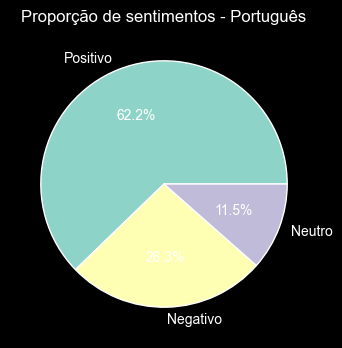

In [13]:
# Proporção de sentimentos em português

df_pt['sentimento'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('Proporção de sentimentos - Português')
plt.ylabel('')
plt.show()

Observação: Dataset desbalanceado (mais Positivos), mas realista para e-commerce.

## 4. Dados em Espanhol: Amazon Reviews

Fonte: mteb/amazon_reviews_multi (es) do HuggingFace
Splits: train + test + validation → dataset único

Rótulos originais: 0,1=Negativo | 2=Neutro | 3,4=Positivo

In [14]:
dataset = load_dataset("mteb/amazon_reviews_multi", "es")

df_es = pd.concat([dataset['train'].to_pandas(), dataset['test'].to_pandas(), dataset['validation'].to_pandas()], ignore_index=True)

In [15]:
# DF_ES:

# 0,1 => Negativo - 2 => Neutro - 3,4 => Positivo. Criamos uma nova coluna com esse "Mapeamento" usando a função .map()

mapa_sentimentos = {
 0: 'Negativo',
 1: 'Negativo',
 2: 'Neutro',
 3: 'Positivo',
 4: 'Positivo'
}

df_es['sentimento'] = df_es['label'].map(mapa_sentimentos)

In [16]:
df_es.drop(axis="columns", columns=['id', 'label', 'label_text'], inplace=True)

df_es.columns = ['texto', 'sentimento']

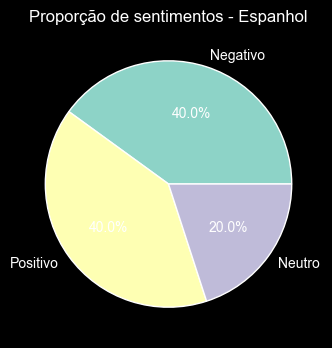

In [17]:
# Proporção de sentimentos em espanhol

df_es['sentimento'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('Proporção de sentimentos - Espanhol')
plt.ylabel('')
plt.show()

## 5. Unificação em um Dataset Único

In [18]:
df_pt['idioma']="pt"
df_es['idioma']='es'

In [19]:
# 1. Concatena
df_multi = pd.concat([df_pt, df_es])

# 2. Embaralha e reseta o índice
# frac=1 -> Pega 100% das linhas aleatoriamente
# random_state=42 -> Garante que o embaralhamento seja sempre o mesmo (importante para reproduzir seus testes)
# reset_index(drop=True) -> Cria um índice novo (0, 1, 2...) e joga fora o antigo bagunçado

df_multi = df_multi.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
df_multi.to_csv('../datasets/df_multi_concatenado.csv', encoding='utf-8',index=False, header=True, sep=';')

## Dataset Multilíngue Final ✅

~380k+ reviews em PT+ES!

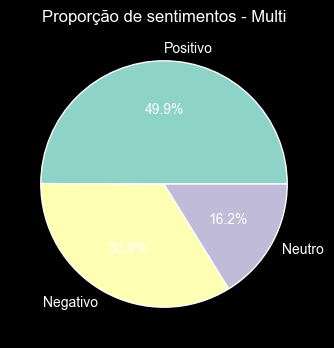

In [21]:
# Proporção de sentimentos em multi

df_multi['sentimento'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('Proporção de sentimentos - Multi')
plt.ylabel('')
plt.show()

Total de linhas em df_multi: 380075


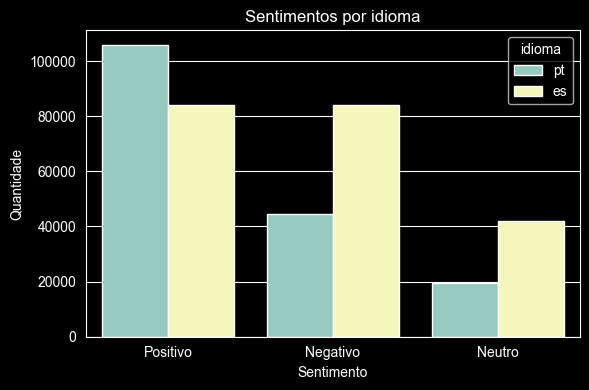

In [22]:
# Tamanho do dataset final

print('Total de linhas em df_multi:', len(df_multi))

# Distribuição de sentimentos por idioma

plt.figure(figsize=(6,4))

sns.countplot(data=df_multi, x='sentimento', hue='idioma')
plt.title('Sentimentos por idioma')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.tight_layout()
plt.show()

## 6. Treinamento Multi-Output

Arquitetura do modelo:

     X = df_multi['texto']                           # Input: textos raw

     y = df_multi[['sentimento', 'idioma']]          # Output: 2 targets

Pipeline:

     TF-IDF (10k features, ngrams 1-2, lowercase)

     MultiOutputClassifier(LogisticRegression)



Por que multi-output? Uma previsão → sentimento E idioma simultaneamente! 🚀

In [23]:
# X: textos; y: DataFrame com duas colunas

X = df_multi['texto']
y = df_multi[['sentimento', 'idioma']]

base_clf = LogisticRegression(solver='lbfgs', max_iter=1000)

modelo_multi = make_pipeline(TfidfVectorizer(max_features=10000, strip_accents='unicode',
 lowercase=True, ngram_range=(1, 2)), MultiOutputClassifier(base_clf))

modelo_multi.fit(X, y)

print("⏳ Treinando modelo...")

# 3. Salvar
joblib.dump(modelo_multi, "../models/modelo_multi.joblib")

print("✅ Novo modelo MULTI salvo em: modelo_multi.joblib")

⏳ Treinando modelo...
✅ Novo modelo MULTI salvo em: modelo_multi.joblib


🎯 Modelo Pronto para Produção!

✅ Sucesso! modelo_multi.joblib salvo em ../models/

Próximos passos:

    Testar em dados não vistos

    Métricas (F1-score por idioma)

    Deploy como API FastAPI


Gerando previsões...

=== Métricas Sentimento ===
Acurácia: 0.8166
F1 Macro: 0.7208
F1 Weighted: 0.8013
Recall Macro: 0.7158
Recall Weighted: 0.8166

=== Métricas Idioma ===
Acurácia: 0.9997
F1 Macro: 0.9997
F1 Weighted: 0.9997
Recall Macro: 0.9997
Recall Weighted: 0.9997

=== Classification Report Sentimento ===
              precision    recall  f1-score   support

    Negativo       0.81      0.90      0.85     25733
      Neutro       0.57      0.33      0.42     12313
    Positivo       0.86      0.92      0.89     37969

    accuracy                           0.82     76015
   macro avg       0.75      0.72      0.72     76015
weighted avg       0.80      0.82      0.80     76015


=== Classification Report Idioma ===
              precision    recall  f1-score   support

          es       1.00      1.00      1.00     42000
          pt       1.00      1.00      1.00     34015

    accuracy                           1.00     76015
   macro avg       1.00      1.00      1.00     

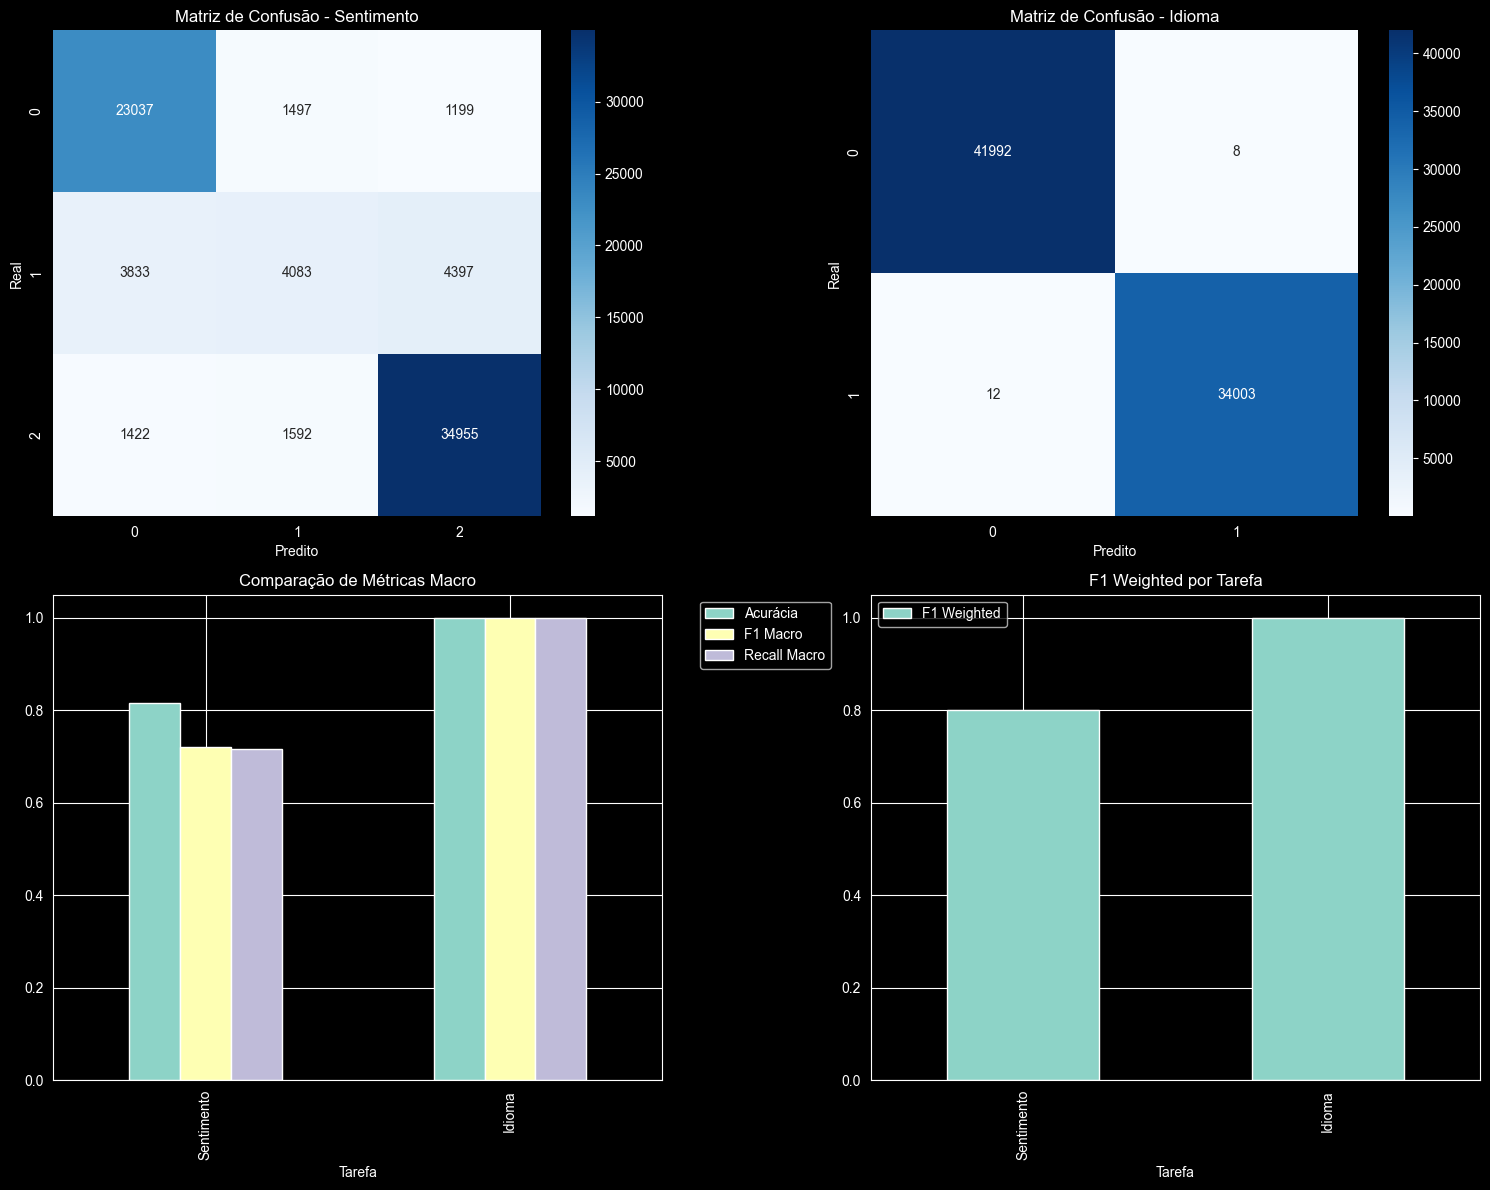


Avaliação concluída! Verifique as métricas e gráficos acima.


In [24]:
X = df_multi['texto']
y = df_multi[['sentimento', 'idioma']]

# Refazer split train/test (mesmo random_state para reproducibilidade)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Previsões no teste
print("Gerando previsões...")
y_pred = modelo_multi.predict(X_test)
y_pred_sent = y_pred[:, 0]  # Primeira coluna: sentimento
y_pred_idioma = y_pred[:, 1]  # Segunda coluna: idioma
y_true_sent = y_test['sentimento']
y_true_idioma = y_test['idioma']

# 3. Calcular métricas
def calcular_metricas(y_true, y_pred, nome):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')

    print(f"\n=== Métricas {nome} ===")
    print(f"Acurácia: {acc:.4f}")
    print(f"F1 Macro: {f1_macro:.4f}")
    print(f"F1 Weighted: {f1_weighted:.4f}")
    print(f"Recall Macro: {recall_macro:.4f}")
    print(f"Recall Weighted: {recall_weighted:.4f}")

    return {
        'accuracy': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted,
        'recall_macro': recall_macro, 'recall_weighted': recall_weighted
    }

metricas_sent = calcular_metricas(y_true_sent, y_pred_sent, "Sentimento")
metricas_idioma = calcular_metricas(y_true_idioma, y_pred_idioma, "Idioma")

# Classification reports
print("\n=== Classification Report Sentimento ===")
print(classification_report(y_true_sent, y_pred_sent))
print("\n=== Classification Report Idioma ===")
print(classification_report(y_true_idioma, y_pred_idioma))

# 4. Visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Matriz de confusão Sentimento
cm_sent = confusion_matrix(y_true_sent, y_pred_sent)
sns.heatmap(cm_sent, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Matriz de Confusão - Sentimento')
axes[0,0].set_xlabel('Predito')
axes[0,0].set_ylabel('Real')

# Matriz de confusão Idioma
cm_idioma = confusion_matrix(y_true_idioma, y_pred_idioma)
sns.heatmap(cm_idioma, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Matriz de Confusão - Idioma')
axes[0,1].set_xlabel('Predito')
axes[0,1].set_ylabel('Real')

# Barras comparativas de métricas
metricas = pd.DataFrame({
    'Tarefa': ['Sentimento', 'Idioma'],
    'Acurácia': [metricas_sent['accuracy'], metricas_idioma['accuracy']],
    'F1 Macro': [metricas_sent['f1_macro'], metricas_idioma['f1_macro']],
    'Recall Macro': [metricas_sent['recall_macro'], metricas_idioma['recall_macro']]
})
metricas.plot(x='Tarefa', kind='bar', ax=axes[1,0])
axes[1,0].set_title('Comparação de Métricas Macro')
axes[1,0].legend(bbox_to_anchor=(1.05, 1))

# F1 Weighted
f1_weighted = pd.DataFrame({
    'Tarefa': ['Sentimento', 'Idioma'],
    'F1 Weighted': [metricas_sent['f1_weighted'], metricas_idioma['f1_weighted']]
})
f1_weighted.plot(x='Tarefa', kind='bar', ax=axes[1,1])
axes[1,1].set_title('F1 Weighted por Tarefa')

plt.tight_layout()
plt.show()

print("\nAvaliação concluída! Verifique as métricas e gráficos acima.")
